# PSF simulation for Cartesian 3DREAM

## Python standard libraries

In [1]:
import numpy as np
from twixreader import Twix
import matplotlib.pyplot as plt
import phase_enc_helper as pe
from scipy import ndimage
from DreamMap_new import global_filter as gf # From DreamMap.py (https://gitlab.com/pehses/3dream-example)
from DreamMap_new import kspace_to_image, image_to_kspace # From DreamMap.py (https://gitlab.com/pehses/3dream-example)
from bart import bart

## Read rawdata

In [2]:
#raw = Twix('/home/niesens/Documents/RawData/20210422/twixdata/us/meas_MID00383_FID26241_pulseq_3dream_cartesian_us_ts1.dat') #ts1
#raw = Twix('/home/niesens/Documents/RawData/20210422/twixdata/us/meas_MID00384_FID26242_pulseq_3dream_cartesian_us_ts2.dat') #ts2
raw = Twix('/home/niesens/Documents/RawData/20210422/twixdata/us/meas_MID00385_FID26243_pulseq_3dream_cartesian_us_ts3.dat') #ts3

imdata = raw[0]['ima'][:]
imgdata=imdata[0,0,0,0,0,0,0,0,0,0,0,0,0]
imgdata = np.swapaxes(imgdata,0,1)

Software version: VD/VE (!?)

scan  0
100 % parsed in 1 s. Estimated 0 s remaining.

## Reco-parameter

In [3]:
Nz = slices = 40
Nx = 40
Ny = 40
fov = 200e-3
os = 2
coils = imgdata.shape[0]

if os != 0:
    Nx = os * Nx
    
subpl_spalt = 8

## Sorting and fft

In [4]:
# STE:
gz_a_c, gy_a_c,_,_ = pe.UlamSpiral(fov,Nz,Ny,comp=True)

kspace_coil_ste = np.zeros([coils,Nz,Ny,Nx],dtype=complex)
Ste_img_coil = np.zeros([coils,Nz,Ny,Nx])
Ste_img = np.zeros([Nz,Ny,Nx])

for k in range(coils):
    SteData = imgdata[k,::2,:]
    for i in range(SteData.shape[0]):
        nz = gz_a_c[i]
        ny = gy_a_c[i]
        kspace_coil_ste[k,int(Nz/2+nz),int(Ny/2+ny),:] = SteData[i,:]
    reco = np.fft.fftshift(kspace_coil_ste[k,:,:,:], axes=[0,1,2])
    reco = np.fft.ifftn(reco, axes=[0,1,2])
    reco = np.fft.ifftshift(reco, axes=[0,1,2])
    Ste_img_coil[k,:,:,:] = abs(reco)
    Ste_img = Ste_img + Ste_img_coil[k,:,:,:]**2
Ste_img = np.sqrt(Ste_img)
    
# FID:
kspace_coil_fid = np.zeros([coils,Nz,Ny,Nx],dtype=complex)
Fid_img_coil = np.zeros([coils,Nz,Ny,Nx])
Fid_img = np.zeros([Nz,Ny,Nx])

for k in range(coils):
    FidData = imgdata[k,1::2,:]
    for i in range(FidData.shape[0]):
        nz = gz_a_c[i]
        ny = gy_a_c[i]
        kspace_coil_fid[k,int(Nz/2+nz),int(Ny/2+ny),:] = FidData[i,:]
    reco = np.fft.fftshift(kspace_coil_fid[k,:,:,:], axes=[0,1,2])
    reco = np.fft.ifftn(reco, axes=[0,1,2])
    reco = np.fft.ifftshift(reco, axes=[0,1,2])
    Fid_img_coil[k,:,:,:] = abs(reco)
    Fid_img = Fid_img + Fid_img_coil[k,:,:,:]**2
Fid_img = np.sqrt(Fid_img)

## Plotting

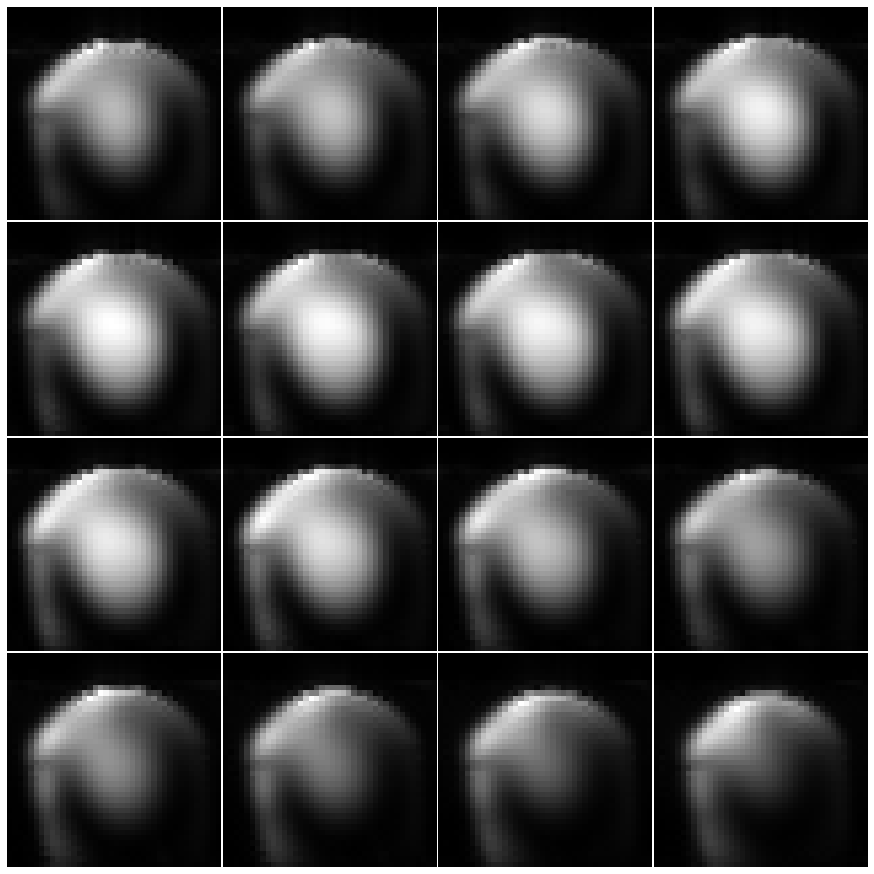

In [6]:
# STE:
columns = 4
rows = 4
fig=plt.figure(figsize=(12, 12))
i=0
for slc in range(14,30):
    i+=1
    fig.add_subplot(rows, columns, i)
    plt.imshow(ndimage.rotate(Ste_img[slc,:,(Nx-int(Nx/2))//2:-(Nx-int(Nx/2))//2],-90),cmap='gray')
    plt.axis('off')
    plt.tight_layout(pad=0.2)

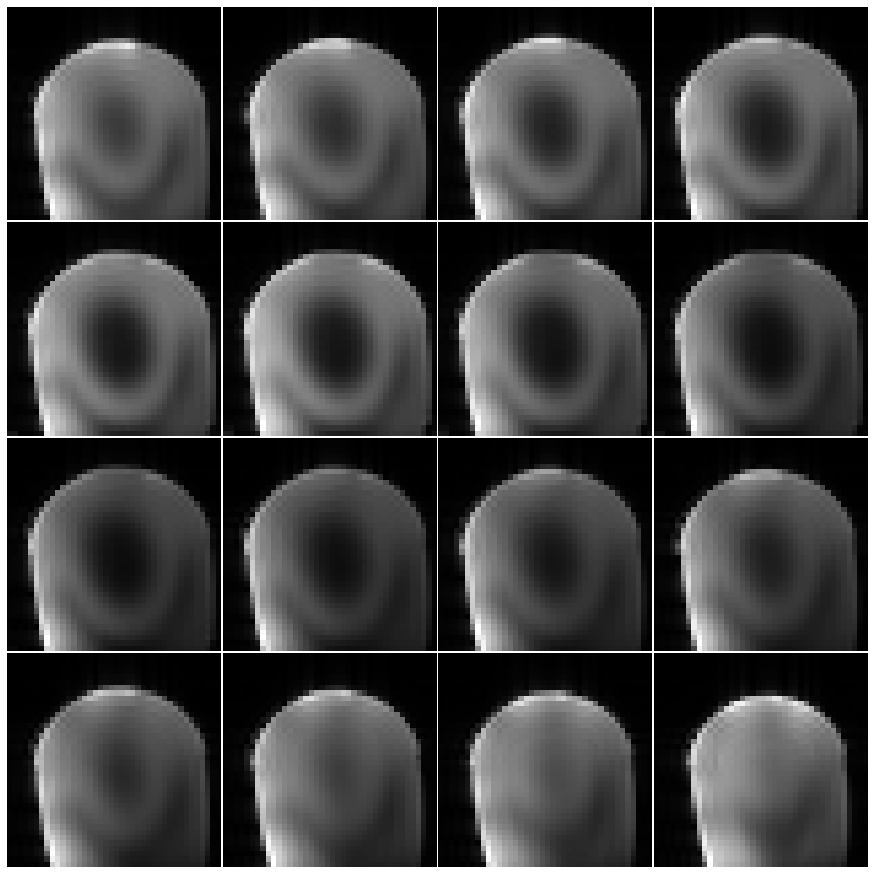

In [7]:
# FID:
columns = 4
rows = 4
fig=plt.figure(figsize=(12, 12))
i=0
for slc in range(14,30):
    i+=1
    fig.add_subplot(rows, columns, i)
    plt.imshow(ndimage.rotate(Fid_img[slc,:,(Nx-int(Nx/2))//2:-(Nx-int(Nx/2))//2],-90),cmap='gray')
    plt.axis('off')
    plt.tight_layout(pad=0.2)

## PSF - unfiltered

(-0.5, 399.5, 399.5, -0.5)

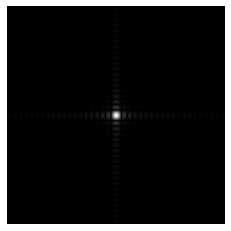

In [10]:
Ste_img_filt2 = np.moveaxis(Ste_img,0,1) # [ny,nz,nx]
PSF_ksp2 = np.ones(np.asarray(Ste_img.shape[:]),dtype=complex) # [ny,nz,nx]
PSF_filt2 = PSF_ksp2.copy()
PSF_filt2 = PSF_filt2[:,:,(Nx-int(Nx/2))//2:-(Nx-int(Nx/2))//2] # [ny,nz,nx] without oversampling

fac = 10
PSF_incrmatr2 = np.zeros([fac*PSF_filt2.shape[0],fac*PSF_filt2.shape[1],fac*PSF_filt2.shape[2]],dtype=complex)
indx2 = int(fac*PSF_filt2.shape[0] / 2) - int(PSF_filt2.shape[0] / 2)
PSF_incrmatr2[indx2:indx2+PSF_filt2.shape[0],indx2:indx2+PSF_filt2.shape[1],indx2:indx2+PSF_filt2.shape[2]] = PSF_filt2.copy()

PSF_img2 = kspace_to_image(PSF_incrmatr2,dim=[0,1,2]) # [ny,nz,nx]
x2 = np.linspace(-20, 20, PSF_img2.shape[0])
PSF_img2 = np.transpose(PSF_img2,[2,0,1]) # [nx,ny,nz]

plt.figure(1)
plt.imshow(abs(PSF_img2[:,:,int(PSF_img2.shape[0]/2)]), cmap='gray')
plt.axis("off")

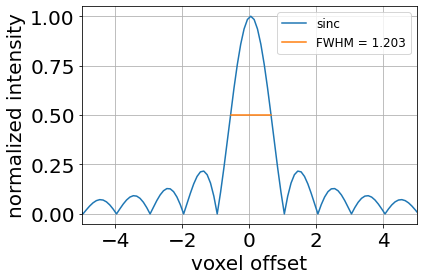

In [11]:
# FWHM calculation:
sinc_unf = abs(PSF_img2[int(PSF_img2.shape[0]/2),:, int(PSF_img2.shape[0]//2)])/(abs(PSF_img2[int(PSF_img2.shape[0]/2),:, int(PSF_img2.shape[0]//2)]).max())
miniposi = min(min(np.where(sinc_unf>=0.5)))
maxiposi = max(max(np.where(sinc_unf>=0.5)))
fwhm2=x2[maxiposi]-x2[miniposi]

plt.figure(2)
plt.plot(x2, sinc_unf, label="sinc")
plt.plot([x2[miniposi],x2[maxiposi]],[0.5,0.5], label="FWHM = {}".format(round(fwhm2,3)))
plt.xlim([-5,5])
plt.grid('on')
plt.xlabel('voxel offset', fontsize=20)
plt.ylabel('normalized intensity', fontsize=20)
plt.legend(fontsize=12)
plt.tick_params(labelsize=20)
plt.show()

## PSF - filtered (R=1)

(-0.5, 399.5, 399.5, -0.5)

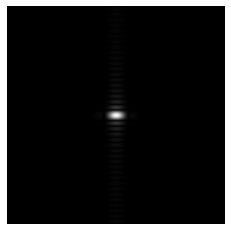

In [8]:
# right dimensions:
Ste_img_filt = np.moveaxis(Ste_img,0,1) # [ny,nz,nx]
Fid_img_filt = np.moveaxis(Fid_img,0,1) # [ny,nz,nx]

PSF_ksp = np.ones(np.asarray(Ste_img_filt.shape[:]),dtype=complex) # [ny,nz,nx]

# sequence parameters:
tr = 3.41e-3
alpha = 60          # preparation FA
beta = 6            # readout FA
dummies = 2         # number of dummy scans before readout echo train starts

# T1 estimate:
t1 = 2              # [s] - approximately Gufi Phantom at 7T: 784e-3; approximately brain: 2s 

# estimation of ti:
ti_r1  = np.zeros([Ny,Nz])
for i in range(gz_a_c.size):
    nz = gz_a_c[i]
    ny = gy_a_c[i]
    ti_r1[int(Ny/2+ny),int(Nz/2+nz)] = tr * (dummies + i)

# global filter:
global_r1, filt = gf(Ste_img_filt, Fid_img_filt, ti_r1, alpha, beta, tr, t1)

# apply global filter in k-space:
PSF_filt = PSF_ksp * filt[...,np.newaxis]

# change k-space of the PSF (zero-padding):
PSF_filt = PSF_filt[:,:,(Nx-int(Nx/2))//2:-(Nx-int(Nx/2))//2] # [ny,nz,nx] without oversampling
fac = 10
PSF_incrmatr = np.zeros([fac*PSF_filt.shape[0],fac*PSF_filt.shape[1],fac*PSF_filt.shape[2]],dtype=complex)
indx = int(fac*PSF_filt.shape[0] / 2) - int(PSF_filt.shape[0] / 2)
PSF_incrmatr[indx:indx+PSF_filt.shape[0],indx:indx+PSF_filt.shape[1],indx:indx+PSF_filt.shape[2]] = PSF_filt.copy()

# PSF in image-space:
PSF_img = kspace_to_image(PSF_incrmatr,dim=[0,1,2]) # [ny,nz,nx]
x = np.linspace(-20, 20, PSF_img.shape[0])
PSF_img = np.transpose(PSF_img,[2,0,1]) # [nx,ny,nz]

# plotting:
plt.figure(1)
plt.imshow(abs(PSF_img[:,:,int(PSF_img.shape[0]/2)]), cmap='gray')
plt.axis("off")

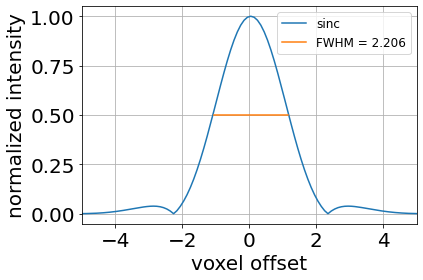

In [9]:
# FWHM calculation:
sinc = abs(PSF_img[int(PSF_img.shape[0]/2),:, int(PSF_img.shape[0]//2)])/(abs(PSF_img[int(PSF_img.shape[0]/2),:, int(PSF_img.shape[0]//2)]).max())
miniposi = min(min(np.where(sinc>=0.5)))
maxiposi = max(max(np.where(sinc>=0.5)))
fwhm=x[maxiposi]-x[miniposi]

plt.figure(2)
plt.plot(x, sinc, label="sinc")
plt.plot([x[miniposi],x[maxiposi]],[0.5,0.5], label="FWHM = {}".format(round(fwhm,3)))
plt.xlim([-5,5])
plt.grid('on')
plt.xlabel('voxel offset', fontsize=20)
plt.ylabel('normalized intensity', fontsize=20)
plt.legend(fontsize=12)
plt.tick_params(labelsize=20)
plt.show()

## PSF - filtered (R=4)

(-0.5, 399.5, 399.5, -0.5)

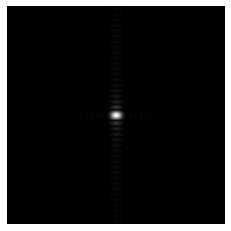

In [12]:
# right dimensions:
Ste_img_filt = np.moveaxis(Ste_img,0,1) # [ny,nz,nx]
Fid_img_filt = np.moveaxis(Fid_img,0,1) # [ny,nz,nx]

# for sensmaps:
PSF_ksp = np.ones([Ste_img_filt.shape[2],Ste_img_filt.shape[0],Ste_img_filt.shape[1],32],dtype=complex) # [nx,ny,nz,nc]
sens = bart(1,'ecalib -m 1 -I',PSF_ksp)

# k-space of accelerated PSF:
PSF_ksp_acc = np.ones([Ste_img_filt.shape[0],Ste_img_filt.shape[1],Ste_img_filt.shape[2],32],dtype=complex) # [ny,nz,nx,nc]
PSF_ksp_acc [::2,::2,:,:] = 0
# sequence parameters:
tr = 3.41e-3
alpha = 60          # preparation FA
beta = 6            # readout FA
dummies = 2         # number of dummy scans before readout echo train starts
# T1 estimate:
t1 = 2              # [s] - approximately Gufi Phantom at 7T: 784e-3; approximately brain: 2s 
# estimation of ti:
ti_r1  = np.zeros([Ny,Nz])
for i in range(gz_a_c.size):
    nz = gz_a_c[i]
    ny = gy_a_c[i]
    ti_r1[int(Ny/2+ny),int(Nz/2+nz)] = tr * (dummies + i)
ti_r1 /= 2
# global filter:
global_r1, filt = gf(Ste_img_filt, Fid_img_filt, ti_r1, alpha, beta, tr, t1)
# apply global filter in k-space:
PSF_filt_acc = PSF_ksp_acc * filt[...,np.newaxis][...,np.newaxis] # [ny,nz,nx,nc]

# Reconstruction of unpadded, but filtered PSF:
PSF_filt_acc = np.transpose(PSF_filt_acc,axes=[2,0,1,3]) # [nx,ny,nz,nc]
PSF_filt = bart(1,'pics -r0.01', PSF_filt_acc, sens) # [nx,ny,nz]
PSF_filt = PSF_filt[(Nx-int(Nx/2))//2:-(Nx-int(Nx/2))//2,:,:] # [nx,ny,nz] without oversampling

# FFT to k-space:
PSF_filt_ksp = image_to_kspace(PSF_filt,dim=(0,1,2)) # [nx,ny,nz]

# Zero-Padding in k-space:
fac = 10
PSF_incrmatr = np.zeros([fac*PSF_filt_ksp.shape[0],fac*PSF_filt_ksp.shape[1],fac*PSF_filt_ksp.shape[2]],dtype=complex)
indx = int(fac*PSF_filt_ksp.shape[0] / 2) - int(PSF_filt_ksp.shape[0] / 2)
PSF_incrmatr[indx:indx+PSF_filt_ksp.shape[0],indx:indx+PSF_filt_ksp.shape[1],indx:indx+PSF_filt_ksp.shape[2]] = PSF_filt_ksp.copy()

# PSF in image-space:
PSF_img3 = kspace_to_image(PSF_incrmatr,dim=[0,1,2])
x3 = np.linspace(-20, 20, PSF_img3.shape[0])

# Plotting:
plt.figure(1)
plt.imshow(abs(PSF_img3[:,:,int(PSF_img3.shape[0]/2)]), cmap='gray')
plt.axis("off")

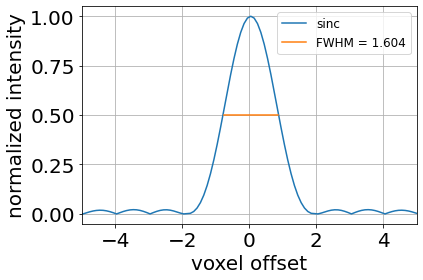

In [13]:
# FWHM calculation:
sinc3 = abs(PSF_img3[int(PSF_img3.shape[0]/2),:,int(PSF_img3.shape[0]//2)]) / (abs(PSF_img3[int(PSF_img3.shape[0]/2),:,int(PSF_img3.shape[0]//2)]).max())
miniposi = min(min(np.where(sinc3>=0.5)))
maxiposi = max(max(np.where(sinc3>=0.5)))
fwhm3=x3[maxiposi]-x3[miniposi]

plt.figure(2)
plt.plot(x3, sinc3, label="sinc")
plt.plot([x3[miniposi],x3[maxiposi]],[0.5,0.5], label="FWHM = {}".format(round(fwhm3,3)))
plt.xlim([-5,5])
plt.grid('on')
plt.xlabel('voxel offset', fontsize=20)
plt.ylabel('normalized intensity', fontsize=20)
plt.legend(fontsize=12)
plt.tick_params(labelsize=20)
plt.show()

## Plotting

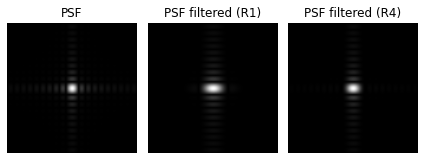

In [14]:
fig, axes = plt.subplots(1, 3)
axes[0].set_title('PSF')
axes[0].imshow(abs(PSF_img2[100:300,100:300,int(PSF_img2.shape[0]/2)]), cmap='gray')
axes[0].axis("off")
axes[1].set_title('PSF filtered (R1)')
axes[1].imshow(abs(PSF_img[100:300,100:300,int(PSF_img.shape[0]/2)]), cmap='gray')
axes[1].axis("off")
axes[2].set_title('PSF filtered (R4)')
axes[2].imshow(abs(PSF_img3[100:300,100:300,int(PSF_img3.shape[0]/2)]), cmap='gray')
axes[2].axis("off")
fig.tight_layout()

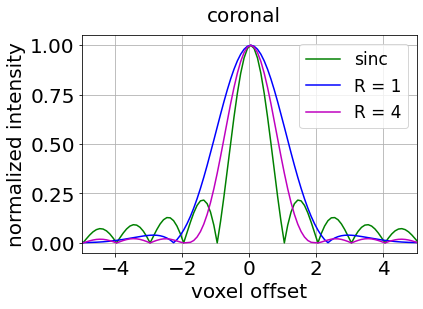

In [15]:
fig = plt.figure()
fig.suptitle('coronal', fontsize=20)
plt.plot(x2, sinc_unf,'g-', label="sinc")
plt.plot(x, sinc, 'b-', label="R = 1")
plt.plot(x3, sinc3, 'm-', label="R = 4")
plt.xlim([-5,5])
plt.grid('on')
plt.xlabel('voxel offset', fontsize=20)
plt.ylabel('normalized intensity', fontsize=20)
plt.legend(fontsize=17)
plt.tick_params(labelsize=20)

In [16]:
print("R1: FWHM = {}".format(fwhm))
print("R4: FWHM = {}".format(fwhm3))

R1: FWHM = 2.2055137844611536
R4: FWHM = 1.6040100250626566
